In [1]:
import axelrod as axl
import numpy as np

from axelrod.action import Action
from axelrod.strategies.lookerup import Plays

import opt_mo
import pandas as pd
C, D = Action.C, Action.D

In [2]:
import matplotlib.pyplot as plt
import matplotlib

In [3]:
font = {"size": 10, "weight": "bold"}
matplotlib.rc("font", **font)

In [4]:
params = [1, 1, 2]

In [5]:
size = opt_mo.get_lookup_table_size(params)
size

16

In [6]:
df_with_g = opt_mo.tools.read_sql_data_frame('../data/with_gambler/main_seed_two.db')

In [7]:
df_with_g.describe()

,exp_index,first_opponent_q_1,first_opponent_q_2,first_opponent_q_3,first_opponent_q_4,second_opponent_q_1,second_opponent_q_2,second_opponent_q_3,second_opponent_q_4,mem_one_p_1,...,gambler_paramater_p_8,gambler_paramater_p_9,gambler_paramater_p_10,gambler_paramater_p_11,gambler_paramater_p_12,gambler_paramater_p_13,gambler_paramater_p_14,gambler_paramater_p_15,gambler_paramater_p_16,gambler_utility
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,124.50000,0.507698,0.462442,0.605849,0.477383,0.543166,0.520013,0.488749,0.434477,0.304099,...,0.397445,0.080240,0.110366,0.563694,0.510710,0.186826,0.281398,0.572572,0.544815,3.016801
std,14.57738,0.311418,0.246798,0.296507,0.324686,0.253389,0.313140,0.285593,0.271763,0.429794,...,0.395712,0.266489,0.308286,0.368641,0.403738,0.351726,0.449055,0.408400,0.404553,0.587725
min,100.00000,0.001510,0.030188,0.016764,0.001682,0.024474,0.001633,0.015054,0.016723,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.657485
25%,112.25000,0.240311,0.215205,0.401697,0.185087,0.359201,0.240951,0.263657,0.190530,0.000000,...,0.000000,0.000000,0.000000,0.189190,0.028714,0.000000,0.000000,0.102779,0.124089,2.560880
50%,124.50000,0.516129,0.457789,0.708506,0.486964,0.556834,0.565621,0.487832,0.499482,0.000000,...,0.258347,0.000000,0.000000,0.638805,0.504242,0.000000,0.000000,0.660296,0.582974,3.039180
75%,136.75000,0.808916,0.625077,0.818243,0.756953,0.743878,0.782732,0.712032,0.613182,0.780403,...,0.832699,0.000000,0.000000,0.876300,1.000000,0.075371,0.970505,1.000000,1.000000,3.392209
max,149.00000,0.979050,0.901108,0.990255,0.965490,0.978199,0.977985,0.991445,0.998740,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.376960


In [46]:
def get_results(row):
    op_one = row[1:5].values
    op_two = row[5:9].values
    
    opponents = [axl.MemoryOnePlayer(p) for p in [op_one, op_two]]

    ps = row[9:13].values
    best_response = axl.MemoryOnePlayer(ps)
    
    pattern = row[27:-1].values
    
    parameters = Plays(
    self_plays=params[0], op_plays=params[1], op_openings=params[2]
    )
    size = opt_mo.get_lookup_table_size(params)

    initial_action = [
        np.random.choice([C, D], p=[pattern[0], 1 - pattern[0]])
        for _ in range(size)
    ]

    gambler = axl.Gambler(
        pattern=pattern[1:],
        parameters=parameters,
        initial_actions=initial_action,
    )
    
    edges = [(0, 2), (0, 3), (1, 2), (1, 3)]
    
    players = [best_response, gambler] + opponents
    
    tournament = axl.Tournament(
        players=players, turns=500, edges=edges, repetitions=1000
    )
    results = tournament.play(progress_bar=False)
    
    return results

In [47]:
results = []
for i, row in df_with_g.iterrows():
    result = get_results(row)
    
    results.append(result)

/anaconda3/envs/opt-mo/lib/python3.6/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


In [ ]:
# dfs = []
# for result in results:
#     dfs.append(pd.DataFrame(result.summarise()))
    
# df = pd.concat(dfs)
# df.to_csv('../data/tournament_results.csv')

In [9]:
df = pd.read_csv('../data/tournament_results.csv')

In [10]:
coop = [result.cooperating_rating[:2] for result in results]
best_coop, gambler_coop = zip(*coop)

In [11]:
x = len(gambler_coop)

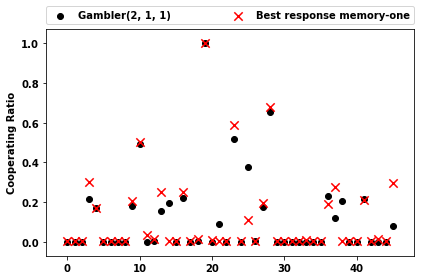

In [12]:
fig, ax = plt.subplots()

plt.scatter(range(x), gambler_coop, label="Gambler(2, 1, 1)", color="black")
plt.scatter(
    range(x),
    best_coop,
    marker="x",
    label="Best response memory-one",
    color="red",
    s=70,
)

plt.ylabel("Cooperating Ratio", fontsize=10, fontweight="bold")
lgd = plt.legend(
    bbox_to_anchor=(0.0, 1.02, 1.0, 0.102),
    loc=3,
    ncol=2,
    mode="expand",
    borderaxespad=0.0,
)

fig.tight_layout()

In [13]:
ps_columns = ["CC_to_C_rate",
              "CD_to_C_rate",
              "DC_to_C_rate",
              "DD_to_C_rate"]

In [10]:
gamblers_results = df[df['Name'].str.contains('Gambler')]

In [11]:
color = '#fdf6e3'
background_color = '#222222'

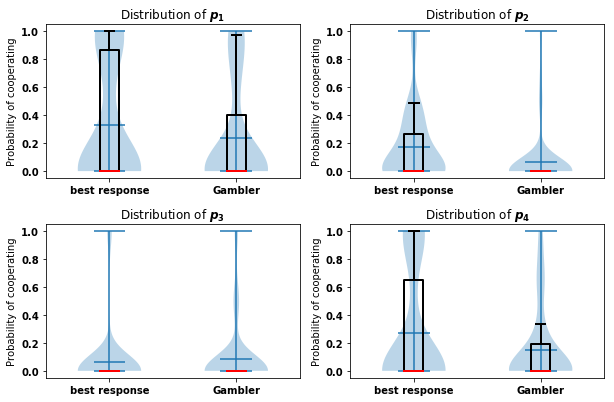

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6.5))

for i, p in enumerate(ps_columns):
    index = (int(i / 2), i % 2)

    axes[index].violinplot(
        [df_with_g["mem_one_p_{}".format(i + 1)], gamblers_results[p].values],
        showmeans=True,
    )

    boxes = axes[index].boxplot(
        [df_with_g["mem_one_p_{}".format(i + 1)], gamblers_results[p].values], showfliers=False
    )
    for bp in boxes['medians']:
        bp.set_color('red')
        bp.set_linewidth(2)
    for bp in boxes['caps']:
        bp.set_color('black')
        bp.set_linewidth(2)
    for bp in boxes['whiskers']:
        bp.set_color('black')
        bp.set_linewidth(2)
    for bp in boxes['boxes']:
        bp.set_color('black')
        bp.set_linewidth(2)

    axes[index].set_title('Distribution of $p_%s$' % (i + 1), fontweight= 'medium')
    axes[index].set_ylabel('Probability of cooperating', fontweight= 'medium')
    matplotlib.pyplot.subplots_adjust(wspace = 0.2, hspace = 0.3)

    plt.setp(axes[index], xticks=[1, 2], xticklabels=["best response", "Gambler"])


    
plt.savefig('../img/gambler_vs_mem_violinplot.pdf')

In [17]:
for q_one, q_two, gambler in zip(df_with_g.loc[:, df_with_g.columns.str.contains('first')].values,
                                    df_with_g.loc[:, df_with_g.columns.str.contains('second')].values,
                                    df_with_g.loc[:, df_with_g.columns.str.contains('gambler_paramater')].values):
    pass

In [18]:
utility = []
x = []
for i, row in df_with_g.iterrows():
    x.append(i)
    p = (row["mem_one_p_1"], row["mem_one_p_2"], row["mem_one_p_3"], row["mem_one_p_4"])
    q_1 = (
        row["first_opponent_q_1"],
        row["first_opponent_q_2"],
        row["first_opponent_q_3"],
        row["first_opponent_q_4"],
    )
    q_2 = (
        row["second_opponent_q_1"],
        row["second_opponent_q_2"],
        row["second_opponent_q_3"],
        row["second_opponent_q_4"],
    )
    utility.append(opt_mo.tournament_utility(p, [q_1, q_2]))


In [19]:
df_with_g["mem_one_utility"] = utility
x = range(len(df_with_g["gambler_utility"]))

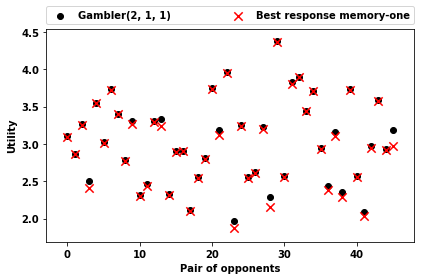

In [21]:
fig, ax = plt.subplots()

plt.scatter(x, df_with_g["gambler_utility"], label="Gambler(2, 1, 1)", color="black")
plt.scatter(
    x,
    df_with_g["mem_one_utility"],
    marker="x",
    label="Best response memory-one",
    color="red",
    s=70,
)

plt.ylabel("Utility", fontsize=10, fontweight="bold")
plt.xlabel("Pair of opponents", fontsize=10, fontweight="bold")
lgd = plt.legend(
    bbox_to_anchor=(0.0, 1.02, 1.0, 0.102),
    loc=3,
    ncol=2,
    mode="expand",
    borderaxespad=0.0,
)

fig.tight_layout()

plt.savefig('../img/gambler_performance_against_mem_one.pdf')